# Clasificador KNN

## Importamos las librerias a utilizar

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
#from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer


from sklearn import preprocessing
from sklearn.metrics import DistanceMetric
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import BallTree
from sklearn.neighbors import KDTree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report

## Cargamos el df

In [12]:
hotel = pd.read_csv('Datasets/hotels_train.csv') 
hotel_t = pd.read_csv('Datasets/hotels_test.csv')
hotel_orig = hotel_t.copy()

## Analisis exploratorio

In [13]:
hotel = hotel[hotel['adr']>0]
total_filas = hotel.shape[0]
hotel.shape

(61028, 32)

In [14]:
hotel['children'].fillna(0,inplace = True)
hotel['country'].fillna('PRT',inplace = True)
hotel['agent'].fillna(0,inplace = True)
hotel['company'].fillna(0,inplace = True)
columnas_eliminar=['meal','arrival_date_year','arrival_date_week_number','arrival_date_day_of_month','id','reservation_status_date']
hotel.drop(columnas_eliminar, axis='columns', inplace=True)

hotel_t['children'].fillna(0,inplace = True)
hotel_t['country'].fillna('PRT',inplace = True)
hotel_t['agent'].fillna(0,inplace = True)
hotel_t['company'].fillna(0,inplace = True)
columnas_eliminar=['meal','arrival_date_year','arrival_date_week_number','arrival_date_day_of_month','id','reservation_status_date']
hotel_t.drop(columnas_eliminar, axis='columns', inplace=True)

## Preprocesamiento

In [15]:
def higher_probability(a,b):
    if a == b:
        return 0
    else:
        return 1

hotel['hotel'] = hotel['hotel'].map({'City Hotel':1,'Resort Hotel':0},na_action=None)
hotel['arrival_date_month'] = hotel['arrival_date_month'].map({'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12},na_action=None)
hotel['country'] = hotel['country'].apply(higher_probability,b='PTR')
hotel['market_segment'] = hotel['market_segment'].map({'Online TA':1,'Groups':2,'Offline TA/TO':3,'Direct':4,'Complementary':5,'Corporate':6,'Aviation':7,'Undefined':8},na_action=None)
hotel['distribution_channel'] = hotel['distribution_channel'].map({'TA/TO':1,'Direct':2,'Corporate':3,'GDS':4,'Undefined':5},na_action=None)
hotel['reserved_room_type'] = hotel['reserved_room_type'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,'P':9,'L':10},na_action=None)
hotel['assigned_room_type'] = hotel['assigned_room_type'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,'P':9,'L':10,'K':11,'I':12},na_action=None)
hotel['agent'] = hotel['agent'].apply(higher_probability,b=0)
hotel['company'] = hotel['company'].apply(higher_probability,b=0)


hotel_t['hotel'] = hotel_t['hotel'].map({'City Hotel':1,'Resort Hotel':0},na_action=None)
hotel_t['arrival_date_month'] = hotel_t['arrival_date_month'].map({'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12},na_action=None)
hotel_t['country'] = hotel_t['country'].apply(higher_probability,b='PTR')
hotel_t['market_segment'] = hotel_t['market_segment'].map({'Online TA':1,'Groups':2,'Offline TA/TO':3,'Direct':4,'Complementary':5,'Corporate':6,'Aviation':7,'Undefined':8},na_action=None)
hotel_t['distribution_channel'] = hotel_t['distribution_channel'].map({'TA/TO':1,'Direct':2,'Corporate':3,'GDS':4,'Undefined':5},na_action=None)
hotel_t['reserved_room_type'] = hotel_t['reserved_room_type'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,'P':9,'L':10},na_action=None)
hotel_t['assigned_room_type'] = hotel_t['assigned_room_type'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,'P':9,'L':10,'K':11,'I':12},na_action=None)
hotel_t['agent'] = hotel_t['agent'].apply(higher_probability,b=0)
hotel_t['company'] = hotel_t['company'].apply(higher_probability,b=0)

hotel.shape

(61028, 26)

In [16]:
#Dummies para deposit_type
hotel = pd.get_dummies(hotel, columns=['deposit_type'], drop_first=True)
hotel_t = pd.get_dummies(hotel_t, columns=['deposit_type'], drop_first=True)

#Dummies para customer_type
hotel = pd.get_dummies(hotel, columns=['customer_type'], drop_first=True)
hotel_t = pd.get_dummies(hotel_t, columns=['customer_type'], drop_first=True)

## Entrenamiento y Prediccion

In [17]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

In [18]:
target='is_canceled'
hotel_x=hotel.drop([target], axis='columns', inplace=False)
hotel_y = hotel[target].copy()

In [19]:

x_train, x_test, y_train, y_test = train_test_split(hotel_x, 
                                                    hotel_y, 
                                                    test_size=0.20,  
                                                    random_state=5, )

In [20]:
min_max_scaler = preprocessing.MinMaxScaler()
x_train_minmax = min_max_scaler.fit_transform(x_train) 
x_test_minmax  = min_max_scaler.transform(x_test)

stand_scaler = preprocessing.StandardScaler()
x_train_norm = stand_scaler.fit_transform(x_train)
x_test_norm=stand_scaler.transform(x_test)

In [21]:
#Grilla de Parámetros
params_grid={ 'n_neighbors':range(2,6), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev']
             }

#Clasificador KNN
knn=KNeighborsClassifier()

scorer_fn = make_scorer(f1_score)
#Random Search con 10 Folds y 10 iteraciones
rand = RandomizedSearchCV(knn, params_grid, cv=10, scoring='accuracy', n_iter=10, random_state=5,error_score='raise')

rand.fit(x_train_minmax, y_train)
rand.cv_results_['mean_test_score']

array([0.80596837, 0.78341715, 0.78499426, 0.79863574, 0.78788236,
       0.78521984, 0.78306906, 0.79873816, 0.78401104, 0.78550638])

KNeighborsClassifier(algorithm='kd_tree', metric='manhattan',
                     weights='distance')
0.8059683693889703
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      6047
           1       0.80      0.80      0.80      6159

    accuracy                           0.80     12206
   macro avg       0.80      0.80      0.80     12206
weighted avg       0.80      0.80      0.80     12206



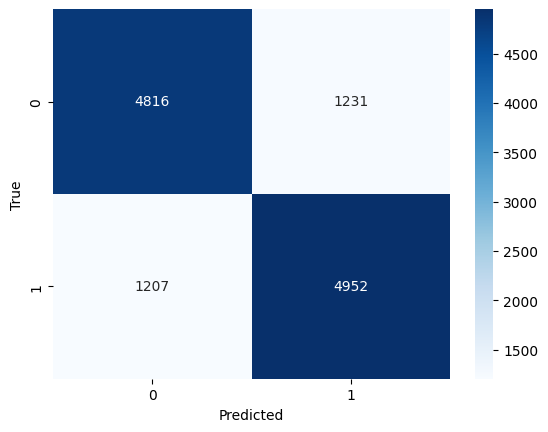

In [22]:
best_tree = rand.best_estimator_
print(best_tree)
print(rand.best_score_)
y_pred_lin=best_tree.predict(x_test_minmax)
metricas(y_pred_lin,y_test)

model = best_tree.fit(x_train,y_train)

In [23]:
rand.fit(x_train_norm, y_train)
rand.cv_results_['mean_test_score']

array([0.80746354, 0.78790284, 0.78571114, 0.80115494, 0.78954137,
       0.78392924, 0.78362186, 0.80119591, 0.78571113, 0.78696051])

KNeighborsClassifier(algorithm='kd_tree', metric='manhattan',
                     weights='distance')
0.8074635365546412
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      6047
           1       0.80      0.80      0.80      6159

    accuracy                           0.80     12206
   macro avg       0.80      0.80      0.80     12206
weighted avg       0.80      0.80      0.80     12206



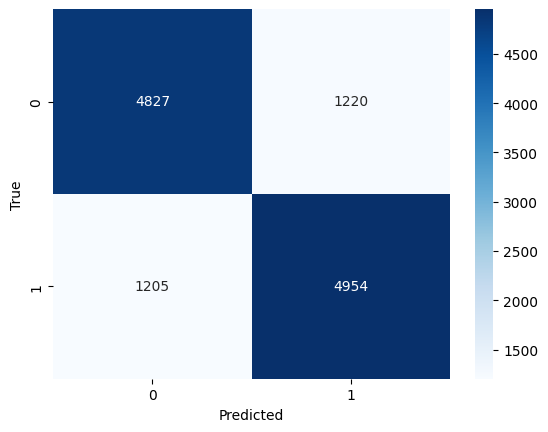

In [24]:
best_tree2 = rand.best_estimator_
print(best_tree2)
print(rand.best_score_)
y_pred_lin2=best_tree2.predict(x_test_norm)
metricas(y_pred_lin2,y_test)

model2 = best_tree2.fit(x_train,y_train)

In [26]:
print(model)
print(model2)

KNeighborsClassifier(algorithm='kd_tree', metric='manhattan',
                     weights='distance')
KNeighborsClassifier(algorithm='kd_tree', metric='manhattan',
                     weights='distance')


In [25]:
import pickle
pickle.dump(model, open("knn_minmax", "wb"))
pickle.dump(model2, open("knn_norm", "wb"))